In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
data = pd.read_csv("bda_dataset9_2.csv")
data.head(10)

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
5,6/1/1985,58.0904
6,7/1/1985,62.6202
7,8/1/1985,63.2485
8,9/1/1985,60.5846
9,10/1/1985,56.3154


Конвертуємо дані зі стовпця DATE у формат datetime, для коректної конвертації можна використати аргументи format='%m/%d/%Y', dayfirst=False

In [5]:
data["DATE"] = pd.to_datetime(data["DATE"], format='%m/%d/%Y', dayfirst=False)
data.head(10)

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
5,1985-06-01,58.0904
6,1985-07-01,62.6202
7,1985-08-01,63.2485
8,1985-09-01,60.5846
9,1985-10-01,56.3154


Будуємо лінійний графік динаміки показника, якими ми прогнозуватимемо

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['DATE'], y=data['IPG2211A2N'], mode='lines', name='Production Index', marker_color = "teal"))
fig.update_layout(title='Electric Power Production', xaxis_title='Date', yaxis_title="Index", template="plotly_white")
fig.show()

За допомогою стовпчикової діаграми візуалізуємо динаміку місячного зростання (у %) аналізованого показника

In [15]:
data["Monthly Growth %"] = data["IPG2211A2N"].pct_change() * 100  

fig = go.Figure([
    go.Bar(
        x=data["DATE"],
        y=data["Monthly Growth %"],
        marker_color='teal',
        name="Місячний приріст"
    )
])

fig.update_layout(
    title="Місячний відсотковий приріст індексу промислового виробництва",
    xaxis_title="Дата",
    yaxis_title="Приріст, %",
    xaxis_tickangle=45,
    template="plotly_white",
    bargap=0.2
)

fig.update_yaxes(showgrid=True)
fig.update_xaxes(showgrid=True)

fig.show()

In [10]:
sorted_data = data.sort_values(by="DATE")
sorted_data

,DATE,IPG2211A2N,Monthly Growth %
0,1985-01-01,72.5052,NaN
1,1985-02-01,70.6720,-2.528370
2,1985-03-01,62.4502,-11.633745
3,1985-04-01,57.4714,-7.972432
4,1985-05-01,55.3151,-3.751953
...,...,...,...
392,2017-09-01,98.6154,-9.470014
393,2017-10-01,93.6137,-5.071926
394,2017-11-01,97.3359,3.976127
395,2017-12-01,114.7212,17.861139


Будуємо графіки автокореляційної і часткової автокореляційної функції для приростів

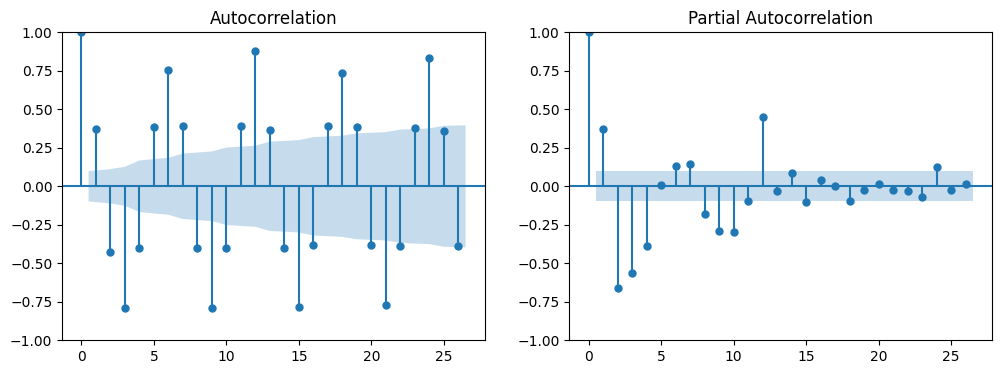

In [20]:
time_series = data.set_index('DATE')['IPG2211A2N']

differenced_series = time_series.diff().dropna()

# Будуємо графіки автокореляційної і часткової автокореляційної функції для приростів
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [ ]:
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:             IPG2211A2N   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1308.795
Date:                Fri, 16 May 2025   AIC                           2623.589
Time:                        17:40:25   BIC                           2635.533
Sample:                    01-01-1985   HQIC                          2628.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0732      0.091      0.805      0.421      -0.105       0.251
ma.L1          0.5450      0.070      7.737      0.000       0.407       0.683
sigma2        43.4248      3.296     13.175      0.0

In [22]:
future_steps = 5
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)

In [23]:
# Створюємо датафрейм, який містить фактичні дані і прогноз
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Прогноз'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Фактичні дані'))

fig.update_layout(title='Прогноз індексу',
                  xaxis_title='Дата',
                  yaxis_title='Індекс',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()